# Set Paths and logger

In [2]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when - is removed, remove also this line and adapt imports
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
if AMDOCS_SRC not in sys.path: 
    sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "out_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
        
from project.project_generic import Project

import pykhaos.utils.notebooks as nb

import time
start_time = time.time()

RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    %load_ext jupyternotify
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20190130-151309 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/out_20190130_151309.log


<IPython.core.display.Javascript object>

# INPUT PARAMS

In [3]:
CCC_TRAIN_TEST_YAML = os.path.join(USECASES_SRC, "churn", "models", "ccc", "input", "ccc_train_test.yaml")

# This name is used when saving the model (Pickle object)
MODEL_NAME = "ccc_comercial_tests" # Results will be stored in a directory named like this

H2O_PORT = 54126 # Be sure no instance running on this port!

# Input data - must be a list but sometime there are problems in the union of h2o dataframes
DP_FILENAME = "/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/"

# Specify the primary key of the model - Usually, msisdn, num_cliente or nif
P_KEY = ["msisdn"] 

# Configuration file for training the h2o model
MODEL_YAML_PATH = os.path.join(USECASES_SRC, "churn", "models", 'ccc', 'input', 'h2o_model.yaml')

# Yaml file of the template for building the excel file
XLSX_REPORT_TEMPLATE_PATH = os.path.join(USECASES_SRC, "churn", "models", "ccc", 'input', 'xlsx_report_template.yaml')

# Save the root path for savings
SAVING_PATH = os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "churn", "ccc")

# Guarantee directoy is unique
UNIQUE_DIRNAME = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

SAVING_PATH_UNIQUE = os.path.join(SAVING_PATH, "results", MODEL_NAME, UNIQUE_DIRNAME)


# IMPORTS and INITIALIZATION

In [4]:
from amdocs_informational_dataset.engine.call_centre_calls import CallCentreCalls
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf, when
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
sys.path.append(os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel", "pykhaos", "external_lib"))
from pykhaos.modeling.model import Model
import yaml
input_data = yaml.load(open(CCC_TRAIN_TEST_YAML))

Using h2o version 3.18.0.10


# Start H2O

In [116]:
from pykhaos.modeling.h2o.h2o_functions import restart_cluster_loop
restart_cluster_loop(port=H2O_PORT, max_mem_size = "32G") # 

Shutdown 3.18.0.10
init 3.18.0.10
Checking whether there is an H2O instance running at http://localhost:54126..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.7.0_79"; Java(TM) SE Runtime Environment (build 1.7.0_79-b15); Java HotSpot(TM) 64-Bit Server VM (build 24.79-b02, mixed mode)
  Starting server from /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbAer2s
  JVM stdout: /tmp/tmpbAer2s/h2o_csanc109_started_from_python.out
  JVM stderr: /tmp/tmpbAer2s/h2o_csanc109_started_from_python.err
  Server is running at http://127.0.0.1:54130
Connecting to H2O server at http://127.0.0.1:54130... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.10
H2O cluster version age:,7 months and 30 days !!!
H2O cluster name:,H2O_from_python_csanc109_4cj4uu
H2O cluster total nodes:,1
H2O cluster free memory:,28.44 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


Done!
locked=False healthy=True
out of while


# Load Data

In [97]:
%%notify -m "CCC_model_pykahos: ended CCCdata "

from churn.models.ccc.data.ccc_data import  CCC_Data
data_abs_data_obj = CCC_Data(input_data=None, filename=DP_FILENAME, pkey_cols=P_KEY)

20190118-111631 [INFO ] ***** locked=False healthy=True
20190118-111631 [INFO ] Trying to import '/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/' hdfs=True parquet=False
20190118-111632 [INFO ] Trying to import hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/
20190118-111633 [ERROR] file hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/ could not be found at node 0


HTTP 500 Server Error:
Server error water.api.HDFSIOException:
  Error: HDFS IO Failure: 
 accessed URI : hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/
 configuration: Configuration: core-default.xml, core-site.xml, mapred-default.xml, mapred-site.xml, yarn-default.xml, yarn-site.xml, hdfs-default.xml, hdfs-site.xml, /opt/cloudera/parcels/SPARK2/lib/spark2/conf/yarn-conf/core-site.xml
 org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
	at org.apache.hadoop.hdfs.server.namenode.ha.StandbyState.checkOperation(StandbyState.java:88)
	at org.apache.hadoop.hdfs.server.namenode.NameNode$NameNodeHAContext.checkOperation(NameNode.java:1835)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.checkOperation(FSNamesystem.java:1515)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesy

20190118-111633 [INFO ] Trying to import hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/


Parse progress: |█████████████████████████████████████████████████████████| 100%


20190118-111638 [INFO ] file hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/ found at node 1


file hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/ found at node 1
**** Preparing __prepare_ccc_data_for_h2o - rows=168085 columns=354
After rgu reduction 89011
About to remove 3 columns
**** Ended __prepare_ccc_data_for_h2o - rows=89011 columns=351


20190118-111641 [INFO ] df_h2o ready to be used!


<IPython.core.display.Javascript object>

# FIT Model

loaded '/var/SP/data/home/csanc109/src/devel/use-cases/churn/models/ccc/input/h2o_model.yaml'
Using test_ratio_split=0.35
(0, 60320)
(1, 28691)
H2O Engine :)
Using h2o version 3.18.0.10
Detected these gridparams:
{'max_after_balance_size': [1.7, 2.5], 'ntrees': [30], 'max_depth': [5]}
**** FIT *****
***** GRIDSEARCH ********
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    max_after_balance_size max_depth ntrees  \
0                      2.5         5     27   
1                      1.7         5     26   

                                                       model_ids  \
0  Grid_GBM_py_292_sid_aa6f_model_python_1547806588081_1_model_1   
1  Grid_GBM_py_292_sid_aa6f_model_python_1547806588081_1_model_0   

              logloss  
0  0.6063567337043875  
1  0.6067500047783867  



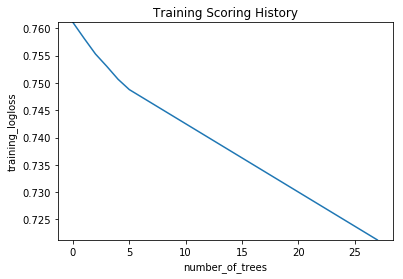

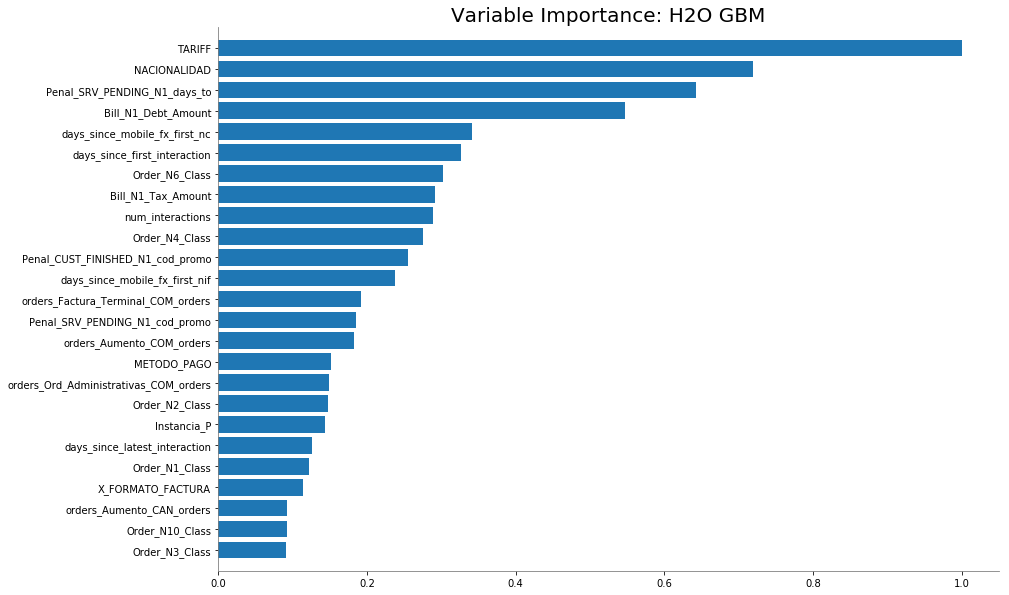

Time in fit method: 00:02:13
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
* * * * * * * METRICS TRAIN * * * * * * * 

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.20435607438
RMSE: 0.452057600732
LogLoss: 0.595357561658
Mean Per-Class Error: 0.380711389715
AUC: 0.674991891847
Gini: 0.349983783695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2952693552: 


,0,1,Error,Rate
0,14814.0,24394.0,0.6222,(24394.0/39208.0)
1,2908.0,15741.0,0.1559,(2908.0/18649.0)
Total,17722.0,40135.0,0.4719,(27302.0/57857.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2952694,0.5355539,242.0
max f2,0.2427358,0.7182696,302.0
max f0point5,0.3408366,0.4687329,175.0
max accuracy,0.3977460,0.6969943,104.0
max precision,0.7308487,1.0,0.0
max recall,0.1225088,1.0,385.0
max specificity,0.7308487,1.0,0.0
max absolute_mcc,0.3024530,0.2266699,233.0
max min_per_class_accuracy,0.3288503,0.6175130,194.0
max mean_per_class_accuracy,0.3198248,0.6192886,208.0


Gains/Lift Table: Avg response rate: 32.23 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100074,0.5223599,2.5558783,2.5558783,0.8238342,0.8238342,0.0255778,0.0255778,155.5878338,155.5878338
,2,0.0201877,0.4535566,2.2912597,2.4224363,0.7385399,0.7808219,0.0233256,0.0489034,129.1259740,142.2436254
,3,0.0300050,0.4319860,2.0209415,2.2910716,0.6514085,0.7384793,0.0198402,0.0687436,102.0941537,129.1071623
,4,0.0400124,0.4171002,1.9021736,2.1938051,0.6131261,0.7071274,0.0190359,0.0877795,90.2173606,119.3805121
,5,0.0500026,0.4107919,1.6639268,2.0879394,0.5363322,0.6730038,0.0166229,0.1044024,66.3926802,108.7939353
,6,0.1000052,0.3878443,1.5613969,1.8246681,0.5032838,0.5881438,0.0780739,0.1824763,56.1396866,82.4668109
,7,0.1500078,0.3750443,1.3876700,1.6790021,0.4472866,0.5411914,0.0693871,0.2518634,38.7670017,67.9002078
,8,0.2000104,0.3635537,1.3265439,1.5908875,0.4275838,0.5127895,0.0663306,0.3181940,32.6543903,59.0887535
,9,0.3000328,0.3467886,1.2174861,1.4664061,0.3924313,0.4726655,0.1217760,0.4399700,21.7486106,46.6406051
,10,0.4002973,0.3351637,1.1648108,1.3908640,0.3754525,0.4483161,0.1167891,0.5567591,16.4810755,39.0863982




Could not find exact threshold 0.291758573955; using closest threshold found 0.291968956631.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265708720139.
Could not find exact threshold 0.291758573955; using closest threshold found 0.291968956631.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265708720139.
Could not find exact threshold 0.291758573955; using closest threshold found 0.291968956631.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265708720139.
Could not find exact threshold 0.291758573955; using closest threshold found 0.291968956631.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265708720139.
Could not find exact threshold 0.291758573955; using closest threshold found 0.291968956631.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265708720139.
Could not find exact threshold 0.291758573955; using closest threshold fo

,0,1,Error,Rate
0,7255.0,13857.0,0.6564,(13857.0/21112.0)
1,1772.0,8270.0,0.1765,(1772.0/10042.0)
Total,9027.0,22127.0,0.5017,(15629.0/31154.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2926412,0.5141596,243.0
max f2,0.2239282,0.7102561,320.0
max f0point5,0.3363102,0.4379233,177.0
max accuracy,0.4016337,0.6844707,94.0
max precision,0.6959795,1.0,0.0
max recall,0.1089298,1.0,391.0
max specificity,0.6959795,1.0,0.0
max absolute_mcc,0.3050803,0.1765252,226.0
max min_per_class_accuracy,0.3272872,0.5912169,191.0
max mean_per_class_accuracy,0.3272872,0.5919328,191.0


Gains/Lift Table: Avg response rate: 32.23 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100148,0.5080313,2.2671166,2.2671166,0.7307692,0.7307692,0.0227046,0.0227046,126.7116572,126.7116572
,2,0.0200295,0.4475764,1.6903939,1.9787553,0.5448718,0.6378205,0.0169289,0.0396335,69.0393935,97.8755254
,3,0.0300122,0.4264360,1.6260010,1.8614220,0.5241158,0.6,0.0162318,0.0558654,62.6001021,86.1422027
,4,0.0401554,0.4162171,1.5708203,1.7880166,0.5063291,0.5763389,0.0159331,0.0717984,57.0820276,78.8016629
,5,0.0500096,0.4077326,1.4147616,1.7144677,0.4560261,0.5526316,0.0139414,0.0857399,41.4761584,71.4467657
,6,0.1000193,0.3859287,1.4775087,1.5959882,0.4762516,0.5144416,0.0738897,0.1596296,47.7508712,59.5988185
,7,0.1500610,0.3743655,1.3332828,1.5083823,0.4297627,0.4862032,0.0667198,0.2263493,33.3282829,50.8382270
,8,0.2000064,0.3630064,1.2242000,1.4374165,0.3946015,0.4633285,0.0611432,0.2874925,22.4200005,43.7416518
,9,0.2999936,0.3465059,1.2200332,1.3649632,0.3932584,0.4399743,0.1219877,0.4094802,22.0033164,36.4963153
,10,0.4001412,0.3348779,1.1166543,1.3028162,0.3599359,0.4199422,0.1118303,0.5213105,11.6654347,30.2816235




Could not find exact threshold 0.291758573955; using closest threshold found 0.292027509163.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265649385766.
Could not find exact threshold 0.291758573955; using closest threshold found 0.292027509163.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265649385766.
Could not find exact threshold 0.291758573955; using closest threshold found 0.292027509163.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265649385766.
Could not find exact threshold 0.291758573955; using closest threshold found 0.292027509163.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265649385766.
Could not find exact threshold 0.291758573955; using closest threshold found 0.292027509163.
Could not find exact threshold 0.26558032477; using closest threshold found 0.265649385766.
Could not find exact threshold 0.291758573955; using closest threshold fo

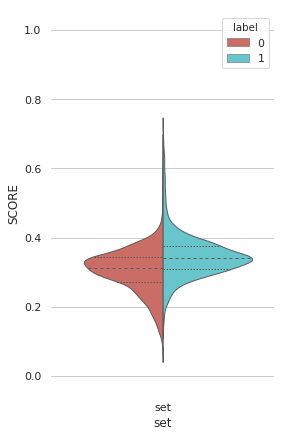

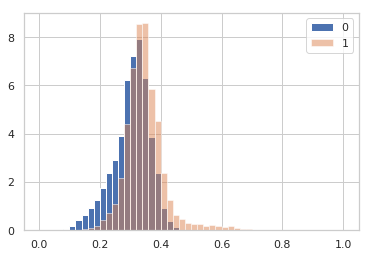

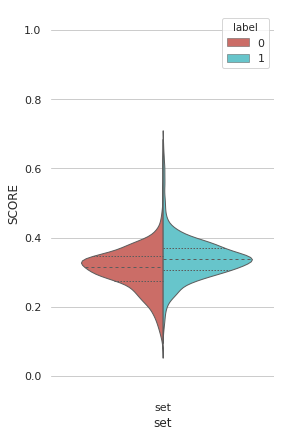

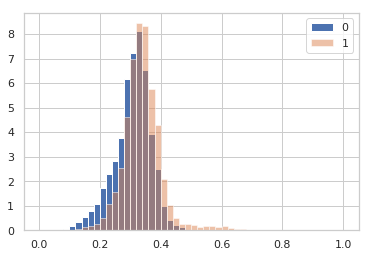

<IPython.core.display.Javascript object>

In [98]:
%%notify -m "CCC_model_pykahos: ended fit "
modeler = Model(MODEL_NAME, MODEL_YAML_PATH, verbose=False)
modeler.fit(data_abs_data_obj)

# SAVE model

In [99]:
%%notify -o

result="FAILED"

import datetime as dt
from churn.utils.constants import YAML_DATA_PREPARATION, YAML_CLOSING_DAY
save_model_path =  os.path.join(SAVING_PATH_UNIQUE, "model")
modeler.save(save_model_path)
result="OK"
"CCC_model_pykahos: [{}] model saved ".format(result)

************** model.py save
['model_fit_config', 'model_fit_params', 'numero_variables', 'target_freq', 'model train metrics', 'target_freq_split', 'test_partition_size', 'model_fit_score_hist', 'model test metrics', 'train_partition_size']
Starting save of model at '/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190118_111624/model/ccc_comercial_tests.pkl'
Creating directory /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190118_111624/model
save h2o_factory /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190118_111624/model
save h2o_factory_saving_path /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190118_111624/model/h2o_factory
Saved h2o model in path /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190118_111624/model/h2o_factory/Grid_GBM_py_292_sid_aa6f_model_python_1547806588081_1_model_1
Saving object at /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_

PicklingError: Can't pickle <class pykhaos.modeling.factory.h2o_factory.H2OFactory at 0x7f1c5b1aec80>: it's not the same object as pykhaos.modeling.factory.h2o_factory.H2OFactory

<IPython.core.display.Javascript object>

# Reporter

In [58]:
%%notify -o
result="FAILED"

from pykhaos.reporting.reporter import Reporter

save_reporter_path = os.path.join(SAVING_PATH_UNIQUE, "reporter")

reporter = Reporter(MODEL_NAME, save_model_path, XLSX_REPORT_TEMPLATE_PATH).set_saving_path(save_reporter_path).create()

print 'Informe generado!'

result="OK"
"CCC_model_pykahos: [{}] reporter finished".format(result)

Reporter __init__ model_id=ccc_comercial_tests model_dir=/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190109_091356/model template_yaml_path=/var/SP/data/home/csanc109/src/devel/use-cases/churn/models/ccc/input/xlsx_report_template.yaml
Loading model /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190109_091356/model/ccc_comercial_tests.pkl
Loading object from /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190109_091356/model/ccc_comercial_tests.pkl
Calling to __setstate H2O Factory
['config', 'params', 'modeler_save_path', 'feature_importance']
<type 'NoneType'>
Calling to __setstate in model
['model_id', 'model_info', 'yaml_filename', 'cols', 'cat_encoding', 'model']
Loaded modeler from path /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190109_091356/model/h2o_factory/Grid_GBM_py_1335_sid_9045_model_python_1547021638053_11556_model_0
Loading report template from '/var/SP/data/home/cs

/opt/cloudera/parcels/Anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Writting sheet 'Intro'
Writting sheet 'Split'
Writting sheet 'Model'
Writting sheet 'Train metrics'
Writting sheet 'Test metrics'
Saved in '/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial_tests/20190109_091356/reporter/ccc_comercial_tests_20190114_121752.xlsx'
Informe generado!


'CCC_model_pykahos: [OK] reporter finished'

<IPython.core.display.Javascript object>

In [59]:
# Uncomment celd if you want to save the sets data (not recommended...)
'''
import h2o
h2o.export_file(modeler.get_sets(), os.path.join(save_model_path, "sets.csv"), force=True)
'''

'\nimport h2o\nh2o.export_file(modeler.get_sets(), os.path.join(save_model_path, "sets.csv"), force=True)\n'

# GENERATE PREDICTIONS

In [9]:
import time
start_time = time.time()
app_name = "CCC_model_predictions_nb"

import pykhaos.utils.pyspark_configuration as pyspark_config
sc, spark, sql_context = pyspark_config.get_spark_session(app_name=app_name, log_level="OFF", min_n_executors = 1, max_n_executors = 10, n_cores = 4,
                         executor_memory = "16g", driver_memory="16g")
print("Ended spark session: {} secs | default parallelism={}".format(time.time() - start_time,
                                                                     sc.defaultParallelism))

Ended spark session: 325.956987858 secs | default parallelism=2


In [24]:
GENERATE_PREDICTIONS = True

assert(GENERATE_PREDICTIONS)

PREDICT_MODEL_NAME = "ccc_comercial_model"
PREDICT_MODEL_PATH =  os.path.join(SAVING_PATH, "results", "ccc_comercial", "20181229_203318", "model")
closing_day = "20190107" 
print("Program will use the model stored at '{}'".format(PREDICT_MODEL_PATH))

from churn.models.ccc.delivery.delivery_manager import make_predictions
df_lever_predict_hidden = make_predictions(spark, PREDICT_MODEL_NAME, PREDICT_MODEL_PATH, closing_day) # returns a column msisdn (anonymized)

print("Prediction size {}".format(df_lever_predict_hidden.count()))

Program will use the model stored at '/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial/20181229_203318/model'
Using h2o version 3.18.0.10
Shutdown 3.18.0.10
init 3.18.0.10
Checking whether there is an H2O instance running at http://localhost:54222..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.7.0_79"; Java(TM) SE Runtime Environment (build 1.7.0_79-b15); Java HotSpot(TM) 64-Bit Server VM (build 24.79-b02, mixed mode)
  Starting server from /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpb8DAk4
  JVM stdout: /tmp/tmpb8DAk4/h2o_csanc109_started_from_python.out
  JVM stderr: /tmp/tmpb8DAk4/h2o_csanc109_started_from_python.err
  Server is running at http://127.0.0.1:54224
Connecting to H2O server at http://127.0.0.1:54224... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.10
H2O cluster version age:,8 months and 6 days !!!
H2O cluster name:,H2O_from_python_csanc109_8gn2n0
H2O cluster total nodes:,1
H2O cluster free memory:,8.89 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


Done!
locked=False healthy=True
out of while
Loading model /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial/20181229_203318/model/ccc_comercial_model.pkl
Loading object from /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial/20181229_203318/model/ccc_comercial_model.pkl
Calling to __setstate H2O Factory
['config', 'params', 'modeler_save_path', 'feature_importance']
Calling to __setstate in model
['model_id', 'model_info', 'yaml_filename', 'cols', 'cat_encoding', 'model']
Loaded modeler from path /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_comercial/20181229_203318/model/h2o_factory/Grid_GBM_py_303_sid_9108_model_python_1546105225071_16200_model_0


20190128-171201 [INFO ] ***** locked=False healthy=True
20190128-171201 [INFO ] Trying to import '/data/udf/vf_es/churn/ccc_model/comercial_unlabeled/df_c20190107_n60_comercial_msisdn_mobileandfbb' hdfs=True parquet=False
20190128-171202 [INFO ] Trying to import hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial_unlabeled/df_c20190107_n60_comercial_msisdn_mobileandfbb
20190128-171204 [ERROR] file hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial_unlabeled/df_c20190107_n60_comercial_msisdn_mobileandfbb could not be found at node 0


HTTP 500 Server Error:
Server error water.api.HDFSIOException:
  Error: HDFS IO Failure: 
 accessed URI : hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial_unlabeled/df_c20190107_n60_comercial_msisdn_mobileandfbb
 configuration: Configuration: core-default.xml, core-site.xml, mapred-default.xml, mapred-site.xml, yarn-default.xml, yarn-site.xml, hdfs-default.xml, hdfs-site.xml, /opt/cloudera/parcels/SPARK2/lib/spark2/conf/yarn-conf/core-site.xml
 org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
	at org.apache.hadoop.hdfs.server.namenode.ha.StandbyState.checkOperation(StandbyState.java:88)
	at org.apache.hadoop.hdfs.server.namenode.NameNode$NameNodeHAContext.checkOperation(NameNode.java:1835)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.checkOperation(FSNamesystem.java:1515)
	at org.apache.hadoop.hdfs.server.namen

20190128-171204 [INFO ] Trying to import hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial_unlabeled/df_c20190107_n60_comercial_msisdn_mobileandfbb
20190128-171205 [ERROR] file hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial_unlabeled/df_c20190107_n60_comercial_msisdn_mobileandfbb could not be found at node 1


HTTP 500 Server Error:
Server error water.util.DistributedException:
  Error: DistributedException from /127.0.0.1:54224: 'null'
  Request: None



20190128-171205 [ERROR] Data could not be obtained


SystemExit: 

/opt/cloudera/parcels/Anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2890: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
running_time_onlymob = "preds_onlymob_for20190114_on20190123_084152"
running_time_mobileandfbb = "preds_mobileandfbb_for20190114_on20190123_171550"
CLOSING_DAY = "20190114"
segments = {"onlymob": running_time_onlymob,
            "mobileandfbb": running_time_mobileandfbb}

from pykhaos.utils.date_functions import move_date_n_days
ccc_start_date_ = move_date_n_days(CLOSING_DAY, -30, str_fmt="%Y%m%d")
print(ccc_start_date_, CLOSING_DAY)

from churn.others.run_churn_delivery_scores_incidences_levers import generate_scores_incidences
df_scores_incidencias = generate_scores_incidences(spark, segments, CLOSING_DAY, ccc_start_date_)

from pykhaos.utils.date_functions import move_date_n_yearmonths
from churn.others.run_churn_delivery_scores_incidences_levers import add_service_problems

# Use the previous YYYYMM to get the service problems
yyyymm_str = move_date_n_yearmonths(CLOSING_DAY[:6], -1)
logger.info("Using yyyymm={} to obtain the service_problems".format(yyyymm_str))
df_scores_incidencias = add_service_problems(spark, df_scores_incidencias, yyyymm_str, closing_day=CLOSING_DAY)

In [23]:
from churn.models.ccc.delivery.delivery_manager import PROJECT_NAME, DIR_DELIVERY
from pykhaos.utils.constants import WHOAMI
NAME_TABLE_DEANONYMIZED = 'tests_es.{}_tmp_{}_{}_notprepared_kk'.format(WHOAMI, PROJECT_NAME, CLOSING_DAY)
name_file_delivery = '{}_delivery_{}_{}'.format(PROJECT_NAME, CLOSING_DAY, dt.datetime.now().strftime("%Y%m%d_%H%M%S"))

from churn.models.ccc.delivery.delivery_manager import merging_process_2, prepare_delivery, make_predictions, DIR_DOWNLOAD
from churn.others.run_churn_delivery_scores_incidences_levers import FINAL_COLS
start_merge = time.time()
df_complete = merging_process_2(df_lever_predict_hidden, df_scores_incidencias, NAME_TABLE_DEANONYMIZED, FINAL_COLS, save_table=True)
if logger: logger.info("merging_process - {} minutes".format( (time.time()-start_merge)/60.0))

NameError: name 'df_lever_predict_hidden' is not defined

In [89]:
df_complete.select("IND_PBMA_SRV", "palanca").groupBy("IND_PBMA_SRV", "palanca").agg(sql_count("*")).show(100,False)

+------------+------------+--------+
|IND_PBMA_SRV|palanca     |count(1)|
+------------+------------+--------+
|1           |NO_COMERCIAL|331797  |
|0           |NO_COMERCIAL|761698  |
|0           |COMERCIAL   |3269273 |
+------------+------------+--------+



In [11]:
PREDICT_MODEL_NAME = "ccc_comercial_model"
CLOSING_DAY = "20190121"
from churn.models.ccc.delivery.delivery_manager import PROJECT_NAME, DIR_DELIVERY
from pykhaos.utils.constants import WHOAMI
NAME_TABLE_DEANONYMIZED = 'tests_es.{}_tmp_{}_{}_notprepared'.format("jmarcoso", PROJECT_NAME, CLOSING_DAY)
name_file_delivery = '{}_delivery_{}_{}'.format(PROJECT_NAME, CLOSING_DAY, dt.datetime.now().strftime("%Y%m%d_%H%M%S"))
from churn.models.ccc.delivery.delivery_manager import merging_process_2, prepare_delivery, make_predictions, DIR_DOWNLOAD


In [12]:
start_delivery = time.time()
prepare_delivery(spark, PROJECT_NAME , CLOSING_DAY, NAME_TABLE_DEANONYMIZED, name_file_delivery, DIR_DOWNLOAD, DIR_DELIVERY)
if logger: logger.info("merging_process - {} minutes".format( (time.time()-start_delivery)/60.0))

Preparing delivery for project='churn_ccc' closing_day='20190121'
Loading info from table 'tests_es.jmarcoso_tmp_churn_ccc_20190121_notprepared'
Results will be written on following filename 'churn_ccc_delivery_20190121_20190130_152602'
All columns will be written: msisdn|comb_score|comb_decile|IND_AVERIAS|IND_SOPORTE|IND_RECLAMACIONES|IND_DEGRAD_ADSL|IND_TIPIF_UCI|IND_PBMA_SRV|DETALLE_PBMA_SRV|palanca
Columns will be written: msisdn|comb_score|comb_decile|IND_AVERIAS|IND_SOPORTE|IND_RECLAMACIONES|IND_DEGRAD_ADSL|IND_TIPIF_UCI|IND_PBMA_SRV|DETALLE_PBMA_SRV|palanca
Number of rows = 4295217
Directory successfully deleted /var/SP/data/home/csanc109/data/download/churn/ccc/churn_ccc_delivery_20190121_20190130_152602
Moving filename='churn_ccc_delivery_20190121_20190130_152602' from dir_download=/var/SP/data/home/csanc109/data/download/churn/ccc/ to local
Downloaded file /var/SP/data/home/csanc109/data/download/churn/ccc/churn_ccc_delivery_20190121_20190130_152602.csv
Merging /var/SP/data/h

20190130-153432 [INFO ] merging_process - 8.46258191665 minutes


In [61]:
# Preparing delivery for project='churn_ccc' closing_day='20190107'
# Loading info from table 'tests_es.csanc109_tmp_churn_ccc_20190107_notprepared'
# Results will be written on following filename 'churn_ccc_delivery_20190107_20190117_205141'
# All columns will be written: msisdn|comb_score|comb_decile|IND_AVERIAS|IND_SOPORTE|IND_RECLAMACIONES|IND_DEGRAD_ADSL|IND_TIPIF_UCI|IND_PBMA_SRV|DETALLE_PBMA_SRV|palanca
# Columns will be written: msisdn|comb_score|comb_decile|IND_AVERIAS|IND_SOPORTE|IND_RECLAMACIONES|IND_DEGRAD_ADSL|IND_TIPIF_UCI|IND_PBMA_SRV|DETALLE_PBMA_SRV|palanca
# Number of rows = 4362768
# Directory successfully deleted /var/SP/data/home/csanc109/data/download/churn/ccc/churn_ccc_delivery_20190107_20190117_205141
# Moving filename='churn_ccc_delivery_20190107_20190117_205141' from dir_download=/var/SP/data/home/csanc109/data/download/churn/ccc/ to local
# Downloaded file /var/SP/data/home/csanc109/data/download/churn/ccc/churn_ccc_delivery_20190107_20190117_205141.csv
# Merging /var/SP/data/home/csanc109/data/download/churn/ccc/churn_ccc_delivery_20190107_20190117_205141/*.csv
# File /var/SP/data/home/csanc109/data/delivery/ccc/churn_ccc_delivery_20190107_20190117_205141.csv successfully created
# To download the file in your local computer, type from your local: 

#  scp csanc109@milan-discovery-edge-387:/var/SP/data/home/csanc109/data/delivery/ccc/churn_ccc_delivery_20190107_20190117_205141.txt <local_directoy>
# Process ended successfully


+---------+---------+------------+-----------+-----------+-----------+-----------------+---------------+-------------+------------+------------------------+
|msisdn   |msisdn_d |comb_score  |comb_decile|IND_AVERIAS|IND_SOPORTE|IND_RECLAMACIONES|IND_DEGRAD_ADSL|IND_TIPIF_UCI|IND_PBMA_SRV|DETALLE_PBMA_SRV        |
+---------+---------+------------+-----------+-----------+-----------+-----------------+---------------+-------------+------------+------------------------+
|644518901|655537865|0.100854345 |0          |0          |0          |0                |0              |0            |0           |None  0  0  0           |
|670323943|655316089|0.24392542  |0          |0          |0          |0                |0              |0            |0           |None  0  0  0           |
|677745379|677379408|0.32423022  |0          |0          |0          |0                |0              |0            |0           |None  0  0  0           |
|696470136|670551152|0.10697282  |0          |0          |

# [OPTIONAL] POST PROCESS ANALYSIS - FIXME (pending to implement in h2o to avoid pandas)

In [ ]:
data = data_abs_data_obj.data()
df_data = data.as_data_frame()
data.types

#train = modeler.get_model_info().get("model train metrics")["scores"]
#test = modeler.get_model_info().get("model test metrics")["scores"]

from pykhaos.reporting.utils.plots import univariate_analysis, univariate_hist
df_uni = univariate_analysis(df_data, "TARIFF", target="label", sort=None) # rows=num tarifas || cols [u'TARIFF', u'positivo', u'total', u'frec_loc', u'frec'], dtype='object')

univariate_hist(df_uni, "TARIFF", sort = None)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
df_ = df_data.copy()

df_pivot_label = pd.pivot_table(df_[["label", "TARIFF"]], columns="label", index="TARIFF", aggfunc=lambda x: len(x))
df_pivot_label.columns=["0", "1"]
import matplotlib.pyplot as plt
ax = df_pivot_label[['0','1']].plot(kind='bar', title ="V comp", figsize=(15, 10), legend=True, fontsize=8)
ax.set_ylabel("V", fontsize=12)
plt.show()

In [ ]:
var1 = "codigo_postal_city"
var2 = "Order_N1_Description"

var = [var1,var2 ]
target = "label"

import numpy as np
from sklearn.preprocessing import MinMaxScaler, Imputer

from reportlab.lib.enums import TA_RIGHT
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer, PageBreak, Table

from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

df_data = df_data[~df_data[target].isna()]
df_data[var1] = df_data[var1].fillna(-1)
df_data[var2] = df_data[var2].fillna("UNKNOWN")
X = np.array(df_data[var].copy())
le = preprocessing.LabelEncoder()
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

X[var.index(var1)] = imp.fit_transform(X[var.index(var1)])
#X[var1] = X[var1].isna().astype('int')
le.fit(X[var.index(var2)])
X[var.index(var2)] = le.transform(X[var.index(var2)])

y = np.array(df_data[target])
dtree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=500)
dtree.fit(X, y)
from pykhaos.reporting.utils.plots import prune

#dtree_prune = prune(dtree)
dtree_prune = dtree

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus


dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                filled=True, rounded=True, feature_names=var,
                special_characters=True, rotate=True, class_names=["NO_COMERCIAL", "COMERCIAL"],
                impurity=False, proportion=True, label='root')

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
filename = '/Users/csanc109/Documents/Projects/Churn/ccc_model/results/images/graph_{}.png'.format(int(time.time()))
graph.write_png(filename)

# SHOW IMAGE FROM FILE
from IPython.display import display
from PIL import Image
display(Image.open(filename))

# UNIVARIANT ANALYSIS

In [ ]:
import yaml
from pykhaos.reporting.type.univariate import Univariate
from churn.models.ccc.data.ccc_data import  CCC_Data

pdf_report_template_path = os.path.join(USECASES_SRC, "churn", "models", "ccc", 'input', 'univariante_template.yaml')

print 'univariant analysis: '
#periods = [201805, 201806, 201807]
default_filename = os.path.join(USECASES_SRC, "churn", "models", "ccc", "input", "ccc_train_test.yaml")
input_data = yaml.load(open(default_filename))
data_abs_data_obj = CCC_Data(input_data)
univariate_info = Univariate(data_abs_data_obj, MODEL_NAME+'_univariate').analysis()
univariate_info.save()
print 'end of analysis: {}'.format(MODEL_NAME+'_univariate')

print 'Generando informe: '
reporter = Reporter() \
    .set_model_info(ModelInfo.load(MODEL_NAME+'_univariate')) \
    .set_template('model/univariante.yaml')\
    .set_saving_path(os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "churn", "ccc", "results"))
reporter.create()
print 'Informe generado!'
